# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [34]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

## Load the Dataset

Specify your transforms as a list if you intend to.
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.ToTensor()])

# Create training set and define training dataloader
trainset = datasets.MNIST('~/Deeplearning with pytorch udacity/DMNIST_Data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


# Create test set and define test dataloader
testset = datasets.MNIST('~/Deeplearning with pytorch udacity/DMNIST_Data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

C:\Users\Lamia\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [57]:
#size of training dataset
print(len(trainloader2.dataset))

30000


Print image size

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


## Preprocessing

### To calculate the exact value of the mean and standard deviation of the training dataset, Normalize function was used and it was found that the dataset has mean of 0.1307 and Standard deviation of 0.3081. After that in block [6], the dataset was downloaded again and the normalization was used as a preprocessing operation. 

In [35]:
def Normalize(dataloader):
    #finding mean and std for input images
    
    summ, squared_sum, num_batches= 0, 0, 0
    
    for data,label in dataloader:
        # Mean over batch, height and width, but not over the channels
        #mean of all images in batch but not over the channels(each channel has its own mean)
        summ += torch.mean(data)
        
        squared_sum += torch.mean(data**2)
        num_batches += 1    
    mean_gray = summ / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std_gray = (squared_sum / num_batches - mean_gray ** 2) ** 0.5
    return mean_gray,std_gray

def Call_Normalizer():
    mean, std=Normalize(trainloader) 
    print("Mean is ",mean.item()," STD is ",std.item())
    return mean,std

Call_Normalizer()

Mean is  0.13066351413726807  STD is  0.30811193585395813


(tensor(0.1307), tensor(0.3081))

### Validation dataset was provided to check overfitting and a plot was created to check this in cell [56]

In [35]:
#Download Normalized dataset
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((-0.7387,), (0.6162,)),
                               ])

# Create training set and define training dataloader
dataset = datasets.MNIST('~/Deeplearning with pytorch udacity/DMNIST_Data', download=True, train=True, transform=transform)
trainset,validset=torch.utils.data.random_split(dataset,[30000,30000])
trainloader2 = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
testset = datasets.MNIST('~/Deeplearning with pytorch udacity/DMNIST_Data', download=True, train=False, transform=transform)
testloader2 = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

To choose the correct mean and standard deviation for MNIST dataset, Normalize function was used on the training dataset 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [7]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


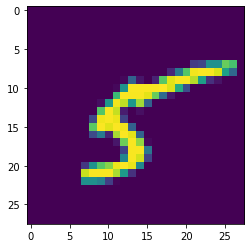

7


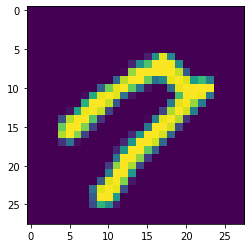

2


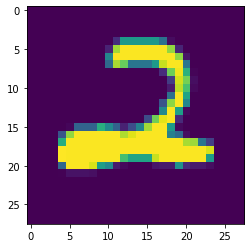

6


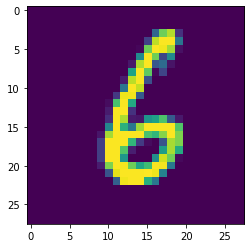

7


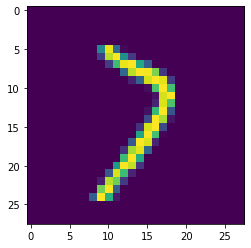

In [8]:
# Explore data
## YOUR CODE HERE ##
show5(trainloader2)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [36]:
## YOUR CODE HERE ##
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [37]:
## YOUR CODE HERE ##
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
## YOUR CODE HERE ##
epochs = 50
TLL=[]
VLL=[]
valid_loss=0;running_loss=0;
for e in range(epochs):
    running_loss = 0
    valid_loss = 0
    for images, labels in trainloader2:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    for images, labels in validloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        valid_loss += loss.item()
    else:
        T=running_loss/len(trainloader2)
        V=valid_loss/len(validloader)    
        print(f"Epoch: {e}", f"    Training loss: {T}",f"    Validation loss: {V}")
        TLL.append(T)
        VLL.append(V)


Epoch: 0     Training loss: 0.9483169896770388     Validation loss: 0.492039121798615
Epoch: 1     Training loss: 0.4361710286597962     Validation loss: 0.35671527202386083
Epoch: 2     Training loss: 0.3637388498703046     Validation loss: 0.3436255106634931
Epoch: 3     Training loss: 0.32394324022251914     Validation loss: 0.3664752213494864
Epoch: 4     Training loss: 0.29807417706322314     Validation loss: 0.274133097428058
Epoch: 5     Training loss: 0.27144636465574123     Validation loss: 0.2627645606425271
Epoch: 6     Training loss: 0.2705589922697051     Validation loss: 0.2681921644728067
Epoch: 7     Training loss: 0.24605742081014842     Validation loss: 0.2966605536480829
Epoch: 8     Training loss: 0.23870961660785334     Validation loss: 0.23703785172737102
Epoch: 9     Training loss: 0.21384019610771873     Validation loss: 0.23786606252797124
Epoch: 10     Training loss: 0.21142838864740152     Validation loss: 0.1942310591321637
Epoch: 11     Training loss: 0.204

In [24]:
#In case you stopped model during training
#torch.no_grad()

Plot the training loss (and validation loss/accuracy, if recorded).

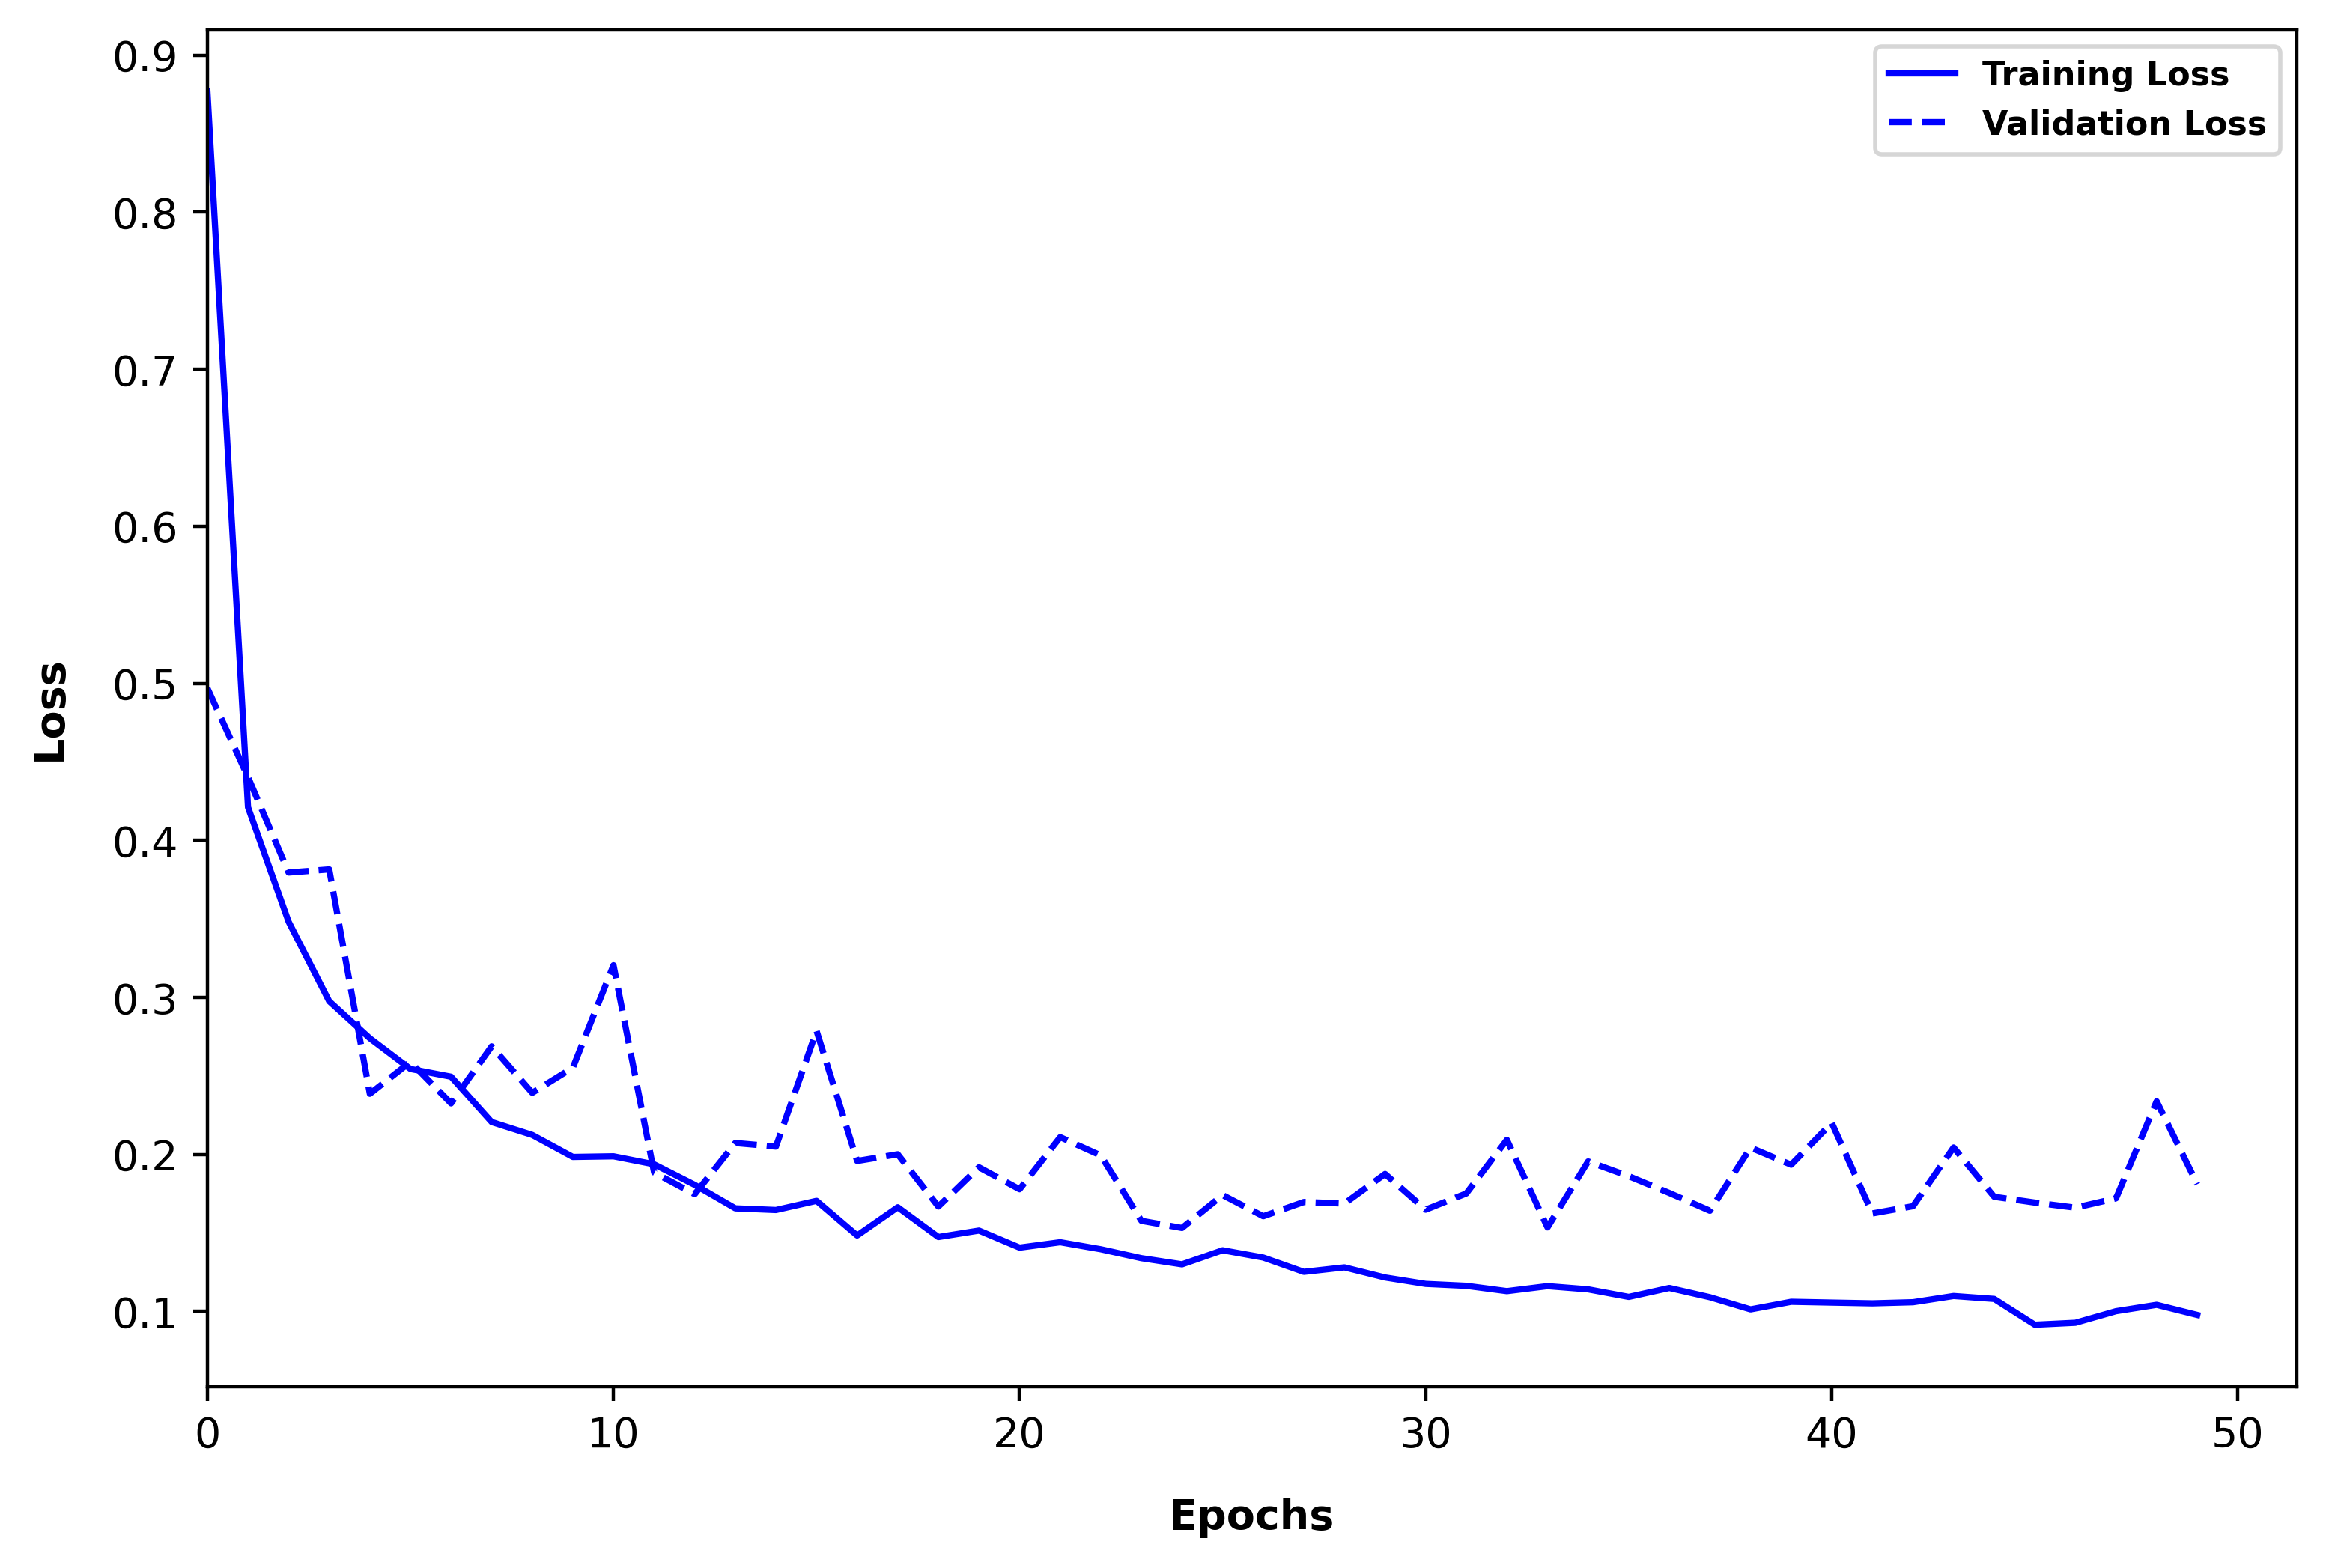

In [56]:
## YOUR CODE HERE ##
fig=plt.figure(figsize=(9,6),dpi=200)
x=[epoch for epoch in range(epochs)]
plt.plot(x,TLL,'b',label='Training Loss')
plt.plot(x,VLL,'b',linestyle='dashed',label='Validation Loss')

plt.xlabel("Epochs",fontweight='bold',labelpad=10)
plt.ylabel("Loss",fontweight='bold',labelpad=10)
plt.xlim(xmin = 0)

plt.legend(prop={'size': 8,'weight':'bold'},loc="best")

plt.savefig(r'Losses.png',bbox_inches="tight")
plt.show()

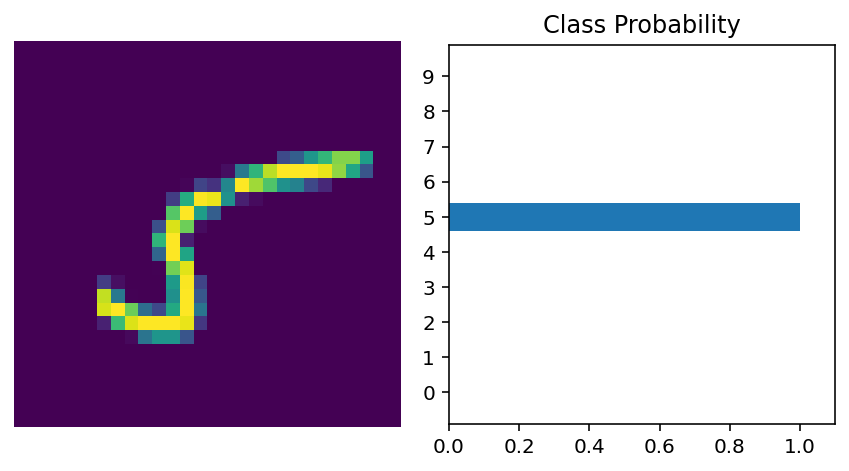

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

# Test out your network!

dataiter = iter(testloader2)
images, labels = dataiter.next()
img = images[1]

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilities
helper.view_classify(img, ps, version='Digit')

In [13]:
print(ps)
top_p, top_class = ps.topk(1, dim=1)
print("Predicted label",top_class)
print("Actual label",labels[1])

tensor([[3.0614e-07, 1.0759e-09, 4.0213e-11, 1.1258e-06, 2.3627e-11, 9.9966e-01,
         3.3928e-04, 1.0765e-13, 3.9885e-06, 1.0025e-10]],
       grad_fn=<ExpBackward>)
Predicted label tensor([[5]])
Actual label tensor(5)


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [38]:
#upload a presaved model
model.load_state_dict(torch.load('MNIST.pt'))


<All keys matched successfully>

In [63]:
## YOUR CODE HERE ##
Yes=0
No=0
for images, labels in  testloader2:
    #print("Loop started")
    # Get the class probabilities
    ps = torch.exp(model(images))
    values, index = ps.topk(1, dim=1)
    # Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
    #print("Size of one batch, ",ps.shape)
    #print(index.shape[0])
    for i in range(index.shape[0]):
        if index[i] == labels[i]:
            #print("Yes index",i)
            Yes+=1
        elif index[i] != labels[i]:
            #print("No index",i)
            No+=1
print("Total accuracy is",(Yes/(Yes+No))*100)


Total accuracy is 95.00999999999999


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!


No further improvement needed. Accuracy is high enough = 95%

## Saving your model
Using `torch.save`, save your model for future loading.

In [33]:
## YOUR CODE HERE ##
torch.save(model.state_dict(), 'MNIST.pt')